__Curate longitudinal dataset based on Ann-Kathrins pathology labels__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import mne
import pandas as pd
import numpy as np

from braindecode.datasets.base import BaseDataset, BaseConcatDataset

from decode_tueg import extract_longitudinal_dataset, plot_longitudinal_interval_hists

Thu Mar 23 12:12:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   27C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
description = pd.read_csv('/home/jovyan/mne_data/TUH/final_tuabEx_description.csv', index_col=0)
description.shape

(33660, 18)

In [3]:
(description.n_samples/description.sfreq).min()

120.0

In [4]:
df = extract_longitudinal_dataset(description, kind='transition', load=False)

n recs 3357 n subj 525


In [5]:
df = extract_longitudinal_dataset(description, 'pathological', False)

n recs 18338 n subj 2892


In [6]:
df = extract_longitudinal_dataset(description, 'non_pathological', False)

n recs 4068 n subj 956


In [7]:
description = []
for ds_name in ['non_pathological', 'pathological', 'transition']:
    description.append(pd.read_csv(f'/home/jovyan/longitudinal/{ds_name}_clean_ages.csv', index_col=0))
description = pd.concat(description)

In [8]:
description['duration'] = description.n_samples / description.sfreq

In [9]:
description.shape

(15088, 21)

In [10]:
min_mins = 15
description = description[description.duration >= min_mins * 60]

In [11]:
description.shape

(4926, 21)

In [12]:
ds = extract_longitudinal_dataset(description, 'transition', True)

n recs 560 n subj 221


/home/jovyan/tueg_age_decoding/decode_tueg.py:2871: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, s in dfs.iteritems():


In [6]:
with open('/home/jovyan/longitudinal/transition.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [7]:
ds = extract_longitudinal_dataset(description, 'non_pathological', True)

n recs 4068 n subj 956


In [8]:
with open('/home/jovyan/longitudinal/non_pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

In [8]:
ds = extract_longitudinal_dataset(description, 'pathological', True)

n recs 18338 n subj 2892


/home/jovyan/tueg_age_decoding/decode_tueg.py:2662: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, s in dfs.iteritems():


In [11]:
with open('/home/jovyan/longitudinal/pathological.pkl', 'wb') as f:
    pickle.dump(ds, f)

__Plot longitudinal datasets__

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle

import torch
import numpy as np
import pandas as pd
from skorch.callbacks import Checkpoint
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_color_codes('deep')

from braindecode.preprocessing import Preprocessor, preprocess
from braindecode import EEGRegressor
from braindecode.models import ShallowFBCSPNet

# from decode_tueg import _create_windows as create_windows

/tmp/ipykernel_1926558/396139984.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def plot_age_hist2(description, ax=None, hue_key=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 2))
    sns.histplot(
        data=description,
        bins=np.linspace(0,100,101,dtype=int),
        x='age',
        kde=True,
        ax=ax,
        hue=hue_key if description[hue_key].nunique() != 1 else None,
        palette=['b', 'r'] if description[hue_key].nunique() != 1 else None,
        color='r' if 0 not in description[hue_key].unique() else 'b',
    );
    return ax
    #ax.set_title(f'train (n={len(train_set.datasets)})')
    #fig.savefig('/home/jovyan/train_dist_wo_gender.jpg', bbox_inches='tight')

In [3]:
workspace = ''  # 'workspace-tueg', ''

In [13]:
with open(f'/home/jovyan/{workspace}/longitudinal/transition_pre_win.pkl', 'rb') as f:
    ds = pickle.load(f)

In [14]:
from decode_tueg import  _add_ages_from_additional_sources, _reject_derivating_ages

In [ ]:
description = _add_ages_from_additional_sources(ds.description)

In [5]:
min_mins = 15  # None
def ds_select_based_on_duration(ds, min_mins):
    df = ds.description
    ids = df[df.n_samples/df.sfreq >= min_mins*60].index.to_list()
    ds = ds.split(ids)['0']
    return ds

In [6]:
ds = ds_select_based_on_duration(ds, min_mins)

In [7]:
ds.description.groupby('subject').head(1).gender.value_counts()

F    274
M    247
Name: gender, dtype: int64

In [8]:
ds.description.pathological.value_counts()

1    756
0    634
Name: pathological, dtype: int64

In [9]:
n_channels = len(ds[0][0])

Text(0, 0.5, 'Count')

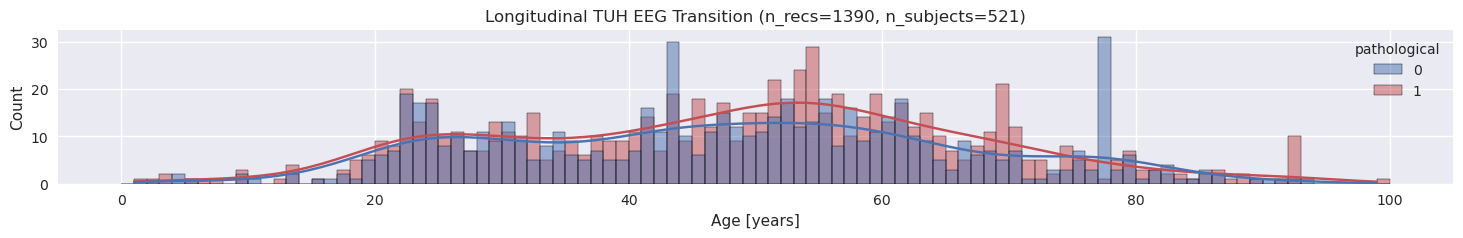

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Transition (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/transition_hist.jpg', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Count')

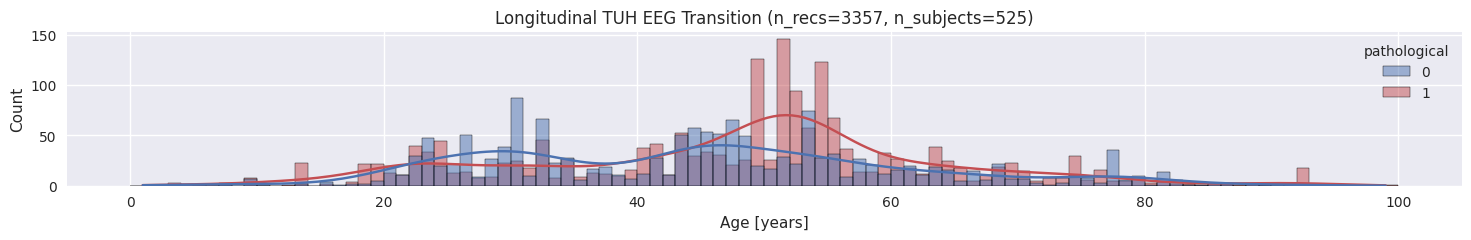

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Transition (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/transition_hist.jpg', bbox_inches='tight', dpi=300)

In [5]:
with open(f'/home/jovyan/{workspace}/longitudinal/non_pathological_pre_win.pkl', 'rb') as f:
    ds = pickle.load(f)

In [7]:
ds = ds_select_based_on_duration(ds, min_mins)

In [8]:
ds.description.groupby('subject').head(1).gender.value_counts()

F    376
M    284
Name: gender, dtype: int64

In [30]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

Text(0, 0.5, 'Count')

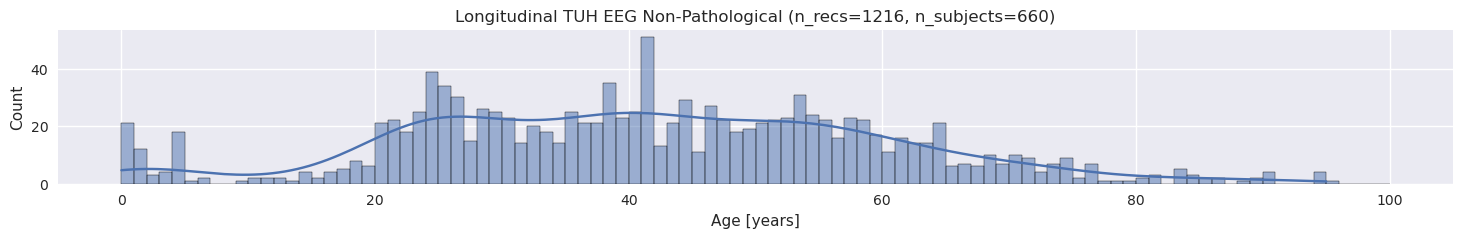

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Non-Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/non_pathological_hist.jpg', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Count')

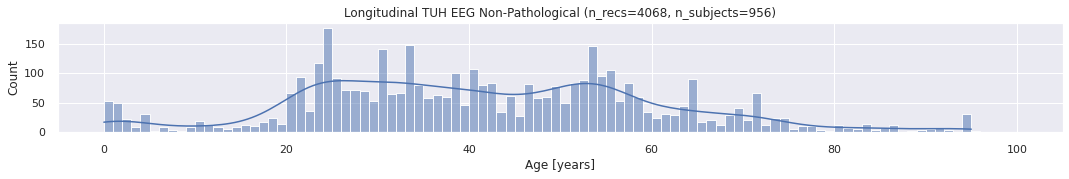

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Non-Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/non_pathological_hist.jpg', bbox_inches='tight', dpi=300)

In [10]:
with open(f'/home/jovyan/{workspace}/longitudinal/pathological_pre_win.pkl', 'rb') as f:
    ds = pickle.load(f)

In [11]:
ds = ds_select_based_on_duration(ds, min_mins)

In [12]:
ds.description.groupby('subject').head(1).gender.value_counts()

M    1186
F    1144
Name: gender, dtype: int64

In [15]:
for n, g in ds.description.groupby('subject'):
    assert g.pathological.nunique() == 1

Text(0, 0.5, 'Count')

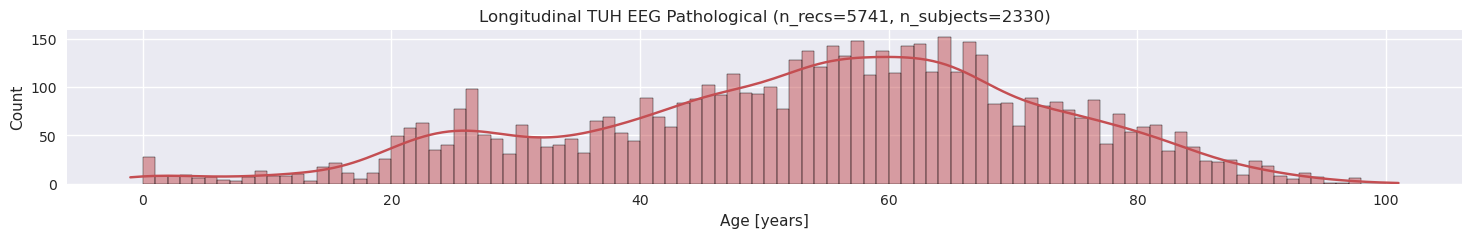

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/pathological_hist.jpg', bbox_inches='tight', dpi=300)

Text(0, 0.5, 'Count')

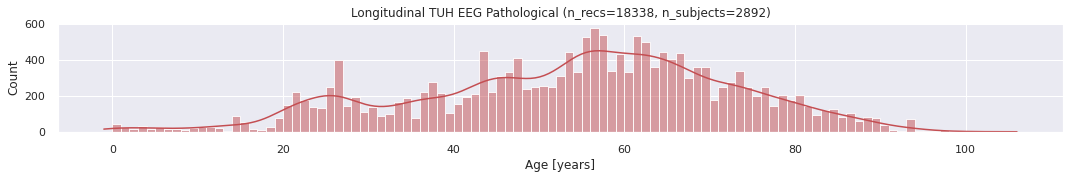

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(18, 2))
plot_age_hist2(ds.description, hue_key='pathological', ax=ax)
ax.set_title(f"Longitudinal TUH EEG Pathological (n_recs={len(ds.description)}, "
             f"n_subjects={len(ds.description.groupby('subject'))})")
ax.set_xlabel('Age [years]')
ax.set_ylabel('Count')
# fig.savefig('/home/jovyan/longitudinal/pathological_hist.jpg', bbox_inches='tight', dpi=300)

In [22]:
import seaborn as sns
sns.set(color_codes=True)

In [23]:
from decode_tueg import age_pyramid

In [97]:
df = ds.description[['pathological', 'gender', 'age', 'subject']]
df['gender'] = df['gender'] == 'F'

In [75]:
df.shape

(3357, 4)

In [76]:
len(df.subject.unique())

525

In [77]:
for n, g in df.groupby(['gender', 'pathological']):
    print(n, g.shape)
    print(n, len(g.subject.unique()))
    print()

(False, 0) (654, 4)
(False, 0) 250

(False, 1) (786, 4)
(False, 1) 251

(True, 0) (855, 4)
(True, 0) 275

(True, 1) (1062, 4)
(True, 1) 275



In [78]:
855+1062+654+786

3357

In [79]:
275+250

525

In [80]:
# why has male non-pathological 250 and male pathological 251? should not happen! this is the transition dataset
# every subject should appear in pathological and non-pathological

In [87]:
subject_wise = False

In [88]:
df.groupby(['subject', 'pathological'], as_index=False).mean() if subject_wise else df

,pathological,gender,age,subject
0,1,False,49,5
1,1,False,49,5
2,1,False,50,5
3,0,False,51,5
4,1,False,52,5
...,...,...,...,...
3352,1,True,43,14951
3353,1,True,43,14951
3354,1,True,43,14951
3355,1,True,43,14951


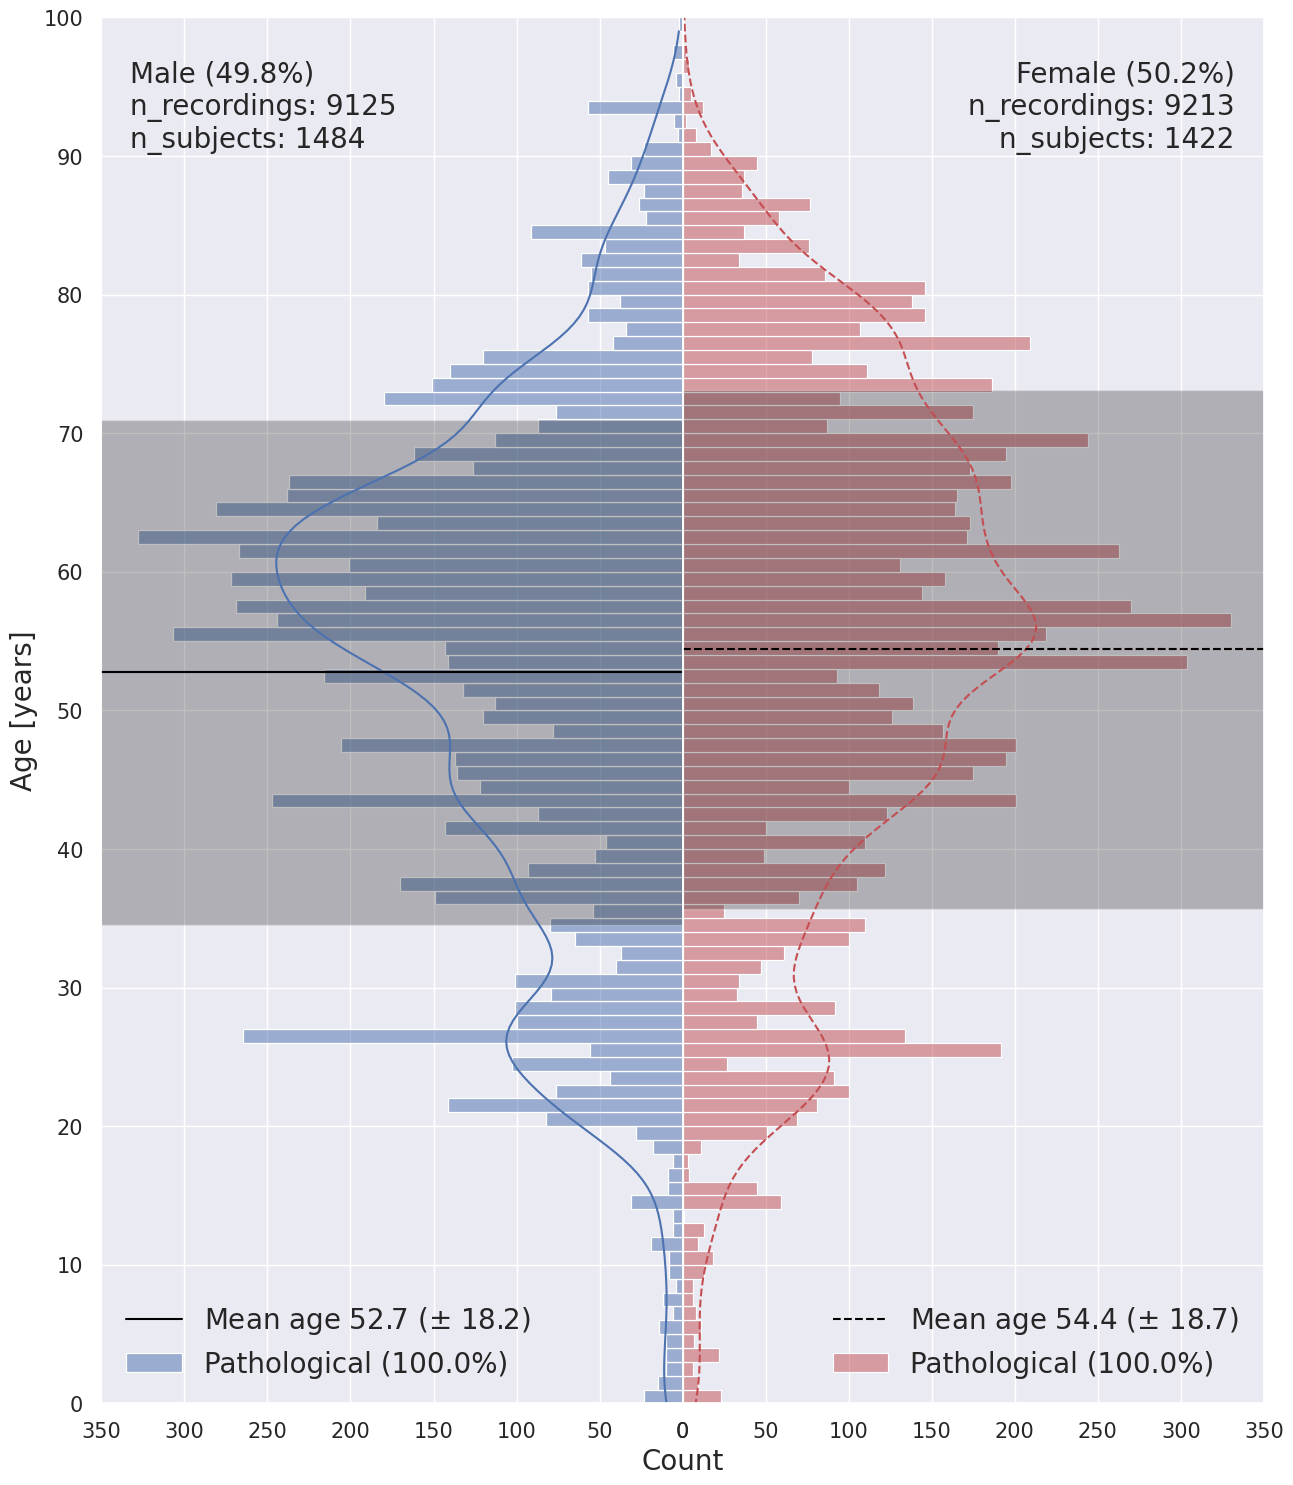

In [102]:
s = 'Recording' if not subject_wise else 'Subject'
ax = age_pyramid(
    df.groupby(['subject', 'pathological'], as_index=False).mean() if subject_wise else df, 
    f'Longitudinal Pathological {s}', 
    ylim=350 if not subject_wise else 22,
#     ylim=50,
    show_title=False,
    fs=20,
    #out_dir='/home/jovyan/', 
)
# ax.title(f'n_reorcings: {len(ds.datasets)}, n_subjects: {ds.description["subject"].nunique()}')
ax[0].get_figure().savefig('/home/jovyan/workspace-tueg/longitudinal_pathological_histogram.png', 
                           dpi=300, bbox_inches='tight')

In [90]:
print("hi")

hi


In [1]:
# analyze time delta between recs of a subject

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [3]:
import pandas as pd
import seaborn as sns
sns.set_color_codes('deep')
import matplotlib.pyplot as plt
plt.style.use('seaborn')

/tmp/ipykernel_3090391/3854903741.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
from decode_tueg import plot_longitudinal_interval_hists

Thu Mar 30 08:26:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:1B:00.0 Off |                  N/A |
| 27%   27C    P8     1W / 250W |      1MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# TODO: compute on session level as multiple recs in one session could bias average time?
# TODO: compute median as outliers could bias average time?

In [6]:
description = []
for ds_name in ['transition', 'pathological', 'non_pathological']:
    description.append(pd.read_csv(f'/home/jovyan/longitudinal/{ds_name}_long_clean_ages.csv', index_col=0))
description = pd.concat(description)

n recs 2777 n subj 1084
[1] 368.56526875369167 694.6150200125751
n recs 373 n subj 158
[0] 515.9441860465116 794.3879067577476
n recs 560 n subj 221
[1 0] 698.377581120944 849.4304072577185


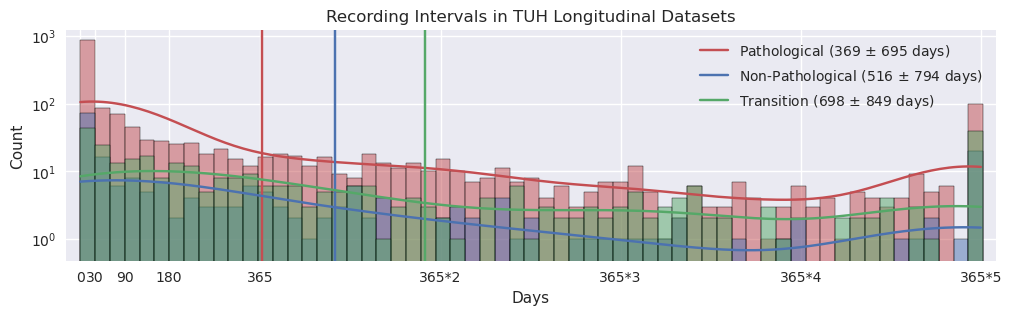

In [7]:
# this uses entire tuabex description
ax = plot_longitudinal_interval_hists(description)
# ax.get_figure().savefig('/home/jovyan/recording_intervals.jpg', dpi=300, bbox_inches='tight')

In [8]:
ds = {'Transition': [], 'Pathological': [], 'Non-pathological': []}
for subj, g in description.groupby('subject'):
    if len(g) < 2:
        continue
    if g.pathological.nunique() == 1:
        if g.pathological.iloc[0] == 0:
            ds['Non-pathological'].append(g)
        elif g.pathological.iloc[0] == 1:
            ds['Pathological'].append(g)
        else:
            raise ValueError
    elif g.pathological.nunique() == 2:
        ds['Transition'].append(g)
    else:
        raise ValueError

In [9]:
transition = pd.concat(ds['Transition'])

In [10]:
transition['Longitudinal'] = 'Transition'

In [11]:
transition.shape, transition.subject.nunique()

((560, 22), 221)

In [12]:
(transition.groupby('subject').size() > 1).sum()

221

In [13]:
non_pathological = pd.concat(ds['Non-pathological'])

In [14]:
non_pathological['Longitudinal'] = 'Non-pathological'

In [15]:
non_pathological.shape, non_pathological.subject.nunique()

((373, 22), 158)

In [17]:
(non_pathological.groupby('subject').size() > 1).sum()

158

In [18]:
pathological = pd.concat(ds['Pathological'])

In [19]:
pathological['Longitudinal'] = 'Pathological'

In [20]:
pathological.shape, pathological.subject.nunique()

((2777, 22), 1084)

In [21]:
(pathological.groupby('subject').size() > 1).sum()

1084

In [22]:
df = pd.concat([non_pathological, pathological, transition])

In [23]:
# count n_recordings per subject'
n_recs_per_subject = df.groupby(['Longitudinal', 'subject'], as_index=False).size()

In [24]:
n_recs_per_subject = n_recs_per_subject.sort_values('Longitudinal')

In [25]:
(n_recs_per_subject.size > 2).all()

True

In [26]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [27]:
from decode_tueg import extract_longitudinal_dataset

In [28]:
import numpy as np
from datetime import datetime, timedelta

In [29]:
#fig, ax_arr = plt.subplots(1, 3, figsize=(12,5), sharex=True, sharey=True)
day_diffs = []
for j, ds_kind in enumerate(['transition', 'non_pathological', 'pathological']):
    df_trans = extract_longitudinal_dataset(description, ds_kind, False)
    if ds_kind == 'transition':
        ds_name = 'Transition'
    if ds_kind == 'non_pathological':
        ds_name = 'Non-pathological' 
    if ds_kind == 'pathological':
        ds_name = 'Pathological' 

    for subj, group in df_trans.groupby('subject'):
        #print(subj)
        dates = [datetime(y, m, d) for i, (y, m, d) in group[['year', 'month', 'day']].iterrows()]
        for i in range(1, len(dates)):
            #print(i, (dates[i] - dates[0]).days)
            day_diffs.append((ds_name, (dates[i] - dates[i-1]).days, subj))

n recs 560 n subj 221
n recs 373 n subj 158
n recs 2777 n subj 1084


In [30]:
df = pd.DataFrame(day_diffs, columns=['Dataset', 'Interval [days]', 'Subject'])

In [31]:
df.shape

(2247, 3)

In [32]:
df = df.sort_values('Dataset')

In [33]:
df.groupby('Dataset').mean()

,Interval [days],Subject
Dataset,,
Non-pathological,516.288372,5624.251163
Pathological,368.887183,5866.359126
Transition,698.849558,3763.557522


In [34]:
df.groupby('Dataset').median()

,Interval [days],Subject
Dataset,,
Non-pathological,147.0,4403.0
Pathological,26.0,5397.0
Transition,345.0,3007.0


In [35]:
# non-zero median interval
df[df['Interval [days]'] > 0].groupby('Dataset').median()

,Interval [days],Subject
Dataset,,
Non-pathological,348.0,3391.0
Pathological,95.0,4452.0
Transition,359.0,2955.0


In [36]:
# non-zero median interval
df[df['Interval [days]'] > 0].groupby('Dataset').mean()

,Interval [days],Subject
Dataset,,
Non-pathological,680.993865,4644.871166
Pathological,466.412248,4735.466766
Transition,722.286585,3615.862805


In [37]:
n_recs_per_subject.groupby(['Longitudinal']).mean()

,subject,size
Longitudinal,,
Non-pathological,5492.556962,2.360759
Pathological,5334.546125,2.561808
Transition,4035.036199,2.533937


In [16]:
from decode_tueg import plot_n_recs_per_subject_and_rec_intervals

In [ ]:
plot_n_recs_per_subject_and_rec_intervals(n_recs_per_subject, df)

Text(0.5, 0, 'Duration [s]')

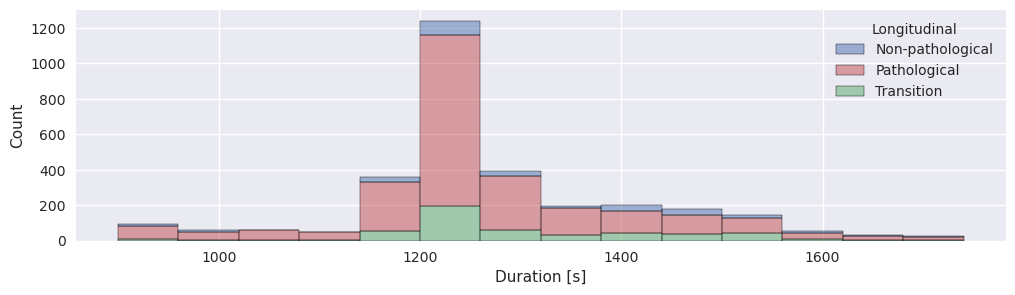

In [39]:
min_s = 900
max_s = 1800
bins = np.linspace(min_s, max_s, int((max_s-min_s)/60), endpoint=False, dtype=int)
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax = sns.histplot(
    data=pd.concat([non_pathological, pathological, transition]), x='duration', ax=ax, bins=bins, alpha=.5,
    hue='Longitudinal', palette=['b', 'r', 'g'], multiple='stack')
#ax.legend(title='')
ax.set_xlabel('Duration [s]')